In [ ]:
from nbdev import *

# Automatic Stopping for Batch-mode Experimentation

> Code for using active learning and automatic stopping for designing experiments

Created with nbdev by Zoltan Puha

## Install

`python -m pip install  git+https://github.com/puhazoli/asbe`

## How to use
ASBE builds on the functional views of modAL, where an AL algorithm can be run by putting together pieces. You need the following ingredients:
- an ITE estimator (`ITEEstimator()`),
- an acquisition function,
- and an assignment function.
- Additionaly, you can add a stopping criteria to your model. 
If all the above are defined, you can construct an `ASLearner`, which will help you in the active learning process.

In [ ]:
from asbe.core import *
from asbe.base import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
N = 1000
X = np.random.normal(size = N*2).reshape((-1,2))
t = np.random.binomial(n = 1, p = 0.5, size = N)
y = np.random.binomial(n = 1, p = 1/(1+np.exp(X[:, 1]*2 + t*3)))
ite = 1/(1+np.exp(X[:, 1]*2 + t*3)) - 1/(1+np.exp(X[:, 1]*2))
a = BaseITEEstimator(LogisticRegression(solver="lbfgs"))
a.fit(X, t, y)

## Learning actively
Similarly, you can create an `ASLearner`, for which you will initialize the dataset and set the preferred modeling options. Let's see how it works:
- we will use XBART to model the treatment effect with a one-model approach
- we will use expected model change maximization
    - for that, we need an approximate model, we will use the `SGDRegressor`
    
You can call `.fit()` on the `ASLearner`, which will by default fit the training data supplied. To select new units from the pool, you just need to call the `query()` method, which will return the selected `X` and the `query_ix` of these units. `ASLearner` expects the `n2` argument, which tells  how many units are queried at once. For sequential AL, we can set this to 1. Additionally, some query strategies can require different treatment effect estimates - EMCM needs uncertainty around the ITE. We can explicitly tell the the `ITEEstimator` to return all the predicted treatment effects. 
Then, we can teach the newly acquired units to the learner, by calling the `teach` function. The `score` function provides an evaluation of the given learner.

In [ ]:
from xbart import XBART
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from copy import deepcopy

In [ ]:
X_train, X_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(
    X, t, y, ite,  test_size=0.8, random_state=1005)
ds = {"X_training": X_train,
     "y_training": y_train,
     "t_training": t_train,
     "X_pool": deepcopy(X_test), 
     "y_pool": deepcopy(y_test),
     "t_pool": deepcopy(t_test),
     "X_test": X_test,
     "y_test": y_test,
      "t_test": t_test,
      "ite_test": ite_test
     }
asl = BaseActiveLearner(estimator = BaseITEEstimator(model = RandomForestClassifier(),
                                         two_model=False),
                        acquisition_function=BaseAcquisitionFunction(),
                        assignment_function=BaseAssignmentFunction(),
                        stopping_function = None,
                        dataset=ds)
asl.fit()
X_new, query_idx = asl.query(no_query=10)
asl.teach(query_idx)
preds = asl.predict(asl.dataset["X_test"])
asl.score()

0.339051085747902

In [ ]:
asl = BaseActiveLearner(estimator = BaseITEEstimator(model = RandomForestClassifier(),
                                         two_model=True),
                        acquisition_function=[BaseAcquisitionFunction(),
                                             BaseAcquisitionFunction(no_query=20)],
                        assignment_function=BaseAssignmentFunction(),
                        stopping_function = None,
                        dataset=ds, al_steps = 10)
resd = pd.DataFrame(asl.simulate())

In [ ]:
import pandas as pd

<AxesSubplot:>

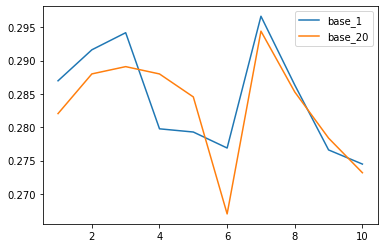

In [ ]:
resd.plot()